# 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from scipy.special import sph_harm
import os

In [ ]:
main_dir = os.getcwd()
if not os.path.exists(os.path.join(main_dir, 'outputs')):
    os.makedirs(os.path.join(main_dir, 'outputs'))
out_dir = os.path.join(main_dir, 'outputs')

# Define Constant
R = 6.3781363000000000E+06     # From the WHU-SWPU-GOGR2022S dataset. Radius Earth (m)

In [ ]:
ggfm_file = 'WHU-SWPU-GOGR2022S.gfc'
n_max = 10  # Degree of the spherical harmonic expansion

C = {}
S = {}

with open(os.path.join(main_dir, ggfm_file), 'r') as f:
    for line in f:
        if line.startswith("gfc"):
            parts = line.split()
            n = int(parts[1])
            m = int(parts[2])
            if n <= n_max:
                Cnm = float(parts[3])
                Snm = float(parts[4])
                C[(n, m)] = Cnm
                S[(n, m)] = Snm

In [ ]:
def delta_g_single_point(theta, phi, C, S, nmax=10):
    """
    Compute gravity anomaly at colatitude=theta, longitude=phi
    using sph_harm from SciPy and the stored Stokes coefficients C, S.

    Parameters
    ----------
    theta : float (radians), colatitude
    phi   : float (radians), longitude
    C, S  : dicts of Stokes coefficients
    nmax  : int, maximum degree

    Returns
    -------
    delta_g : float
        Gravity anomaly at this point (in m/s^2 if used with GM/R^2).
    """
    val_sum = 0.0
    for n in range(3, nmax+1):
        for m in range(0, n+1):
            # Spherical harmonic for degree n, order m
            Ynm = sph_harm(m, n, phi, theta)  # complex

            # Real part ~ P_n^m(cosθ) cos(mφ)
            # Imag part ~ P_n^m(cosθ) sin(mφ)
            Cnm = C.get((n, m), 0.0)
            Snm = S.get((n, m), 0.0)
            

            # Add the combination: C_{nm}*Re(Ynm) + S_{nm}*Im(Ynm)
            val_sum += (n - 1) * (Cnm * Ynm.real + Snm * Ynm.imag) # (R/r)^n, was omitted here because exercise said we took as already included the radial-dependent.

    delta_g_val = val_sum # I did not multiply by GM/R^2, because it is normalized gravity anomally
    return delta_g_val

In [ ]:
# Define lat/lon arrays
step = 1  # Step size in degrees for the grid
lat_vals = np.arange(-90, 90, step)
lon_vals = np.arange(-180, 180, step)

# Prepare a 2D array for the anomaly
delta_g_map = np.zeros((len(lat_vals), len(lon_vals)))

for i, lat in enumerate(lat_vals):
    # colatitude in radians:
    theta = np.radians(90.0 - lat)
    for j, lon in enumerate(lon_vals):
        phi = np.radians(lon + 180.0) 
        # Calculate anomaly at this grid point
        delta_g_map[i, j] = delta_g_single_point(theta, phi, C, S, nmax=n_max)

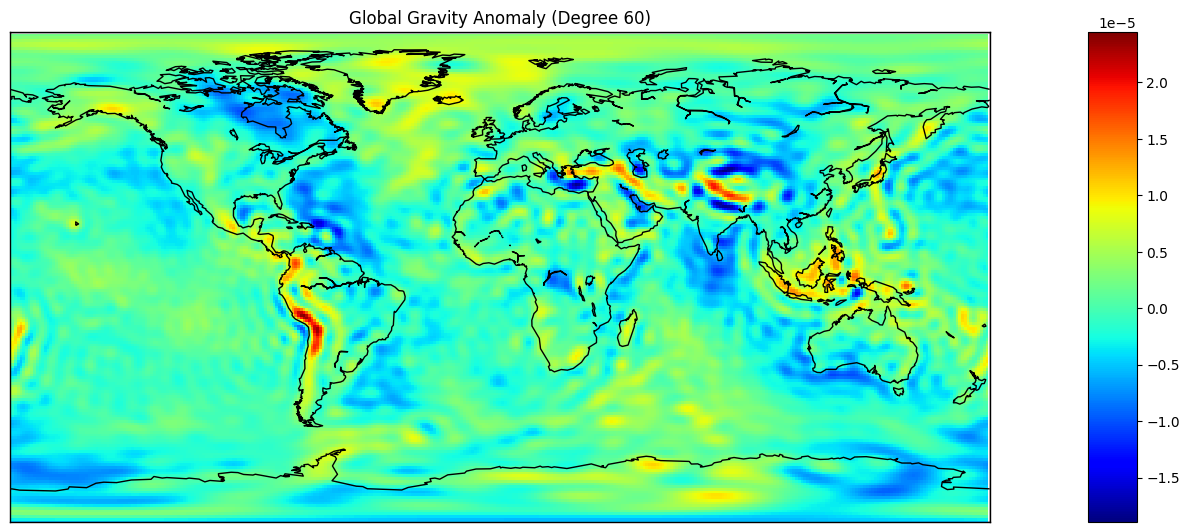

In [ ]:
map = Basemap(projection='cyl', llcrnrlat=-90, urcrnrlat=90, llcrnrlon=-180, urcrnrlon=180, resolution='c')
#map = Basemap(projection='robin', lon_0=0, resolution='i')

lon_grid, lat_grid = np.meshgrid(lon_vals, lat_vals) 

x, y = map(lon_grid, lat_grid)  

fig = plt.figure(figsize=(12,6)) 

map.drawcoastlines() 
map.drawmapboundary()  

cs = map.pcolormesh(x, y, delta_g_map, cmap='jet', shading='auto') 

cbar = map.colorbar(cs, location='right', pad='10%')  

plt.title(f'Global Gravity Anomaly (Degree {n_max})')

plt.tight_layout()  

plt.savefig(os.path.join(out_dir, f'global_gravity_anomaly_{n_max}.png'))
plt.show() 